# Mini Project 2

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**


###  Hypothesis Testing of Standard Assumptions Theoretical Financial Mathematics

In the theory of mathematical finance, it is common to assume the log returns of a stock/index are normally distributed.


Investigate if the log returns of stocks or indexes of your choosing are normally distributed. Some suggestions for exploration include:

    1) Test if there are period of times when the log-returns of a stock/index have evidence of normal distribution.
    
    2) Test if removing extremal return data creates a distribution with evidence of being normal.
    
    3) Create a personalized portfolio of stocks with historical log return data that is normally distributed.
    
    4) Test if the portfolio you created in the first mini-project has significant periods of time with evidence of normally distributed log returns.
    
    5) Gather x-number of historical stock data and just perform a normality test on their log return data to see if any of the stocks exhibit evidence of log returns that are normally distributed.

#  1) Test if there are period of times when the log-returns of a stock/index have evidence of normal distribution.


In [442]:
import yfinance as yf
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from scipy.stats import shapiro, zscore, normaltest, laplace, kstest, probplot

In [443]:
#ticker = "^GSPC"  # S&P500 index
ticker = "NVDA"
# I set auto_adjust=True to ensure the price data reflects total return by accounting for dividends and stock splits.
# This gives an accurate and consistent log returns that truly represent changes in investment value over time.
data = yf.download(ticker, start="2015-01-01", end="2024-12-31", auto_adjust=True)
log_returns = np.log(data['Close'] / data['Close'].shift(1)).dropna()

[*********************100%***********************]  1 of 1 completed


In [444]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2015-01-02,0.483066,0.486665,0.475386,0.483066,113680000
2015-01-05,0.474906,0.484505,0.472747,0.483066,197952000
2015-01-06,0.460508,0.476106,0.460028,0.475626,197764000
2015-01-07,0.459308,0.467947,0.457868,0.463868,321808000
2015-01-08,0.476586,0.479466,0.464348,0.464588,283780000


#### Below I plot a histogram of the log_return data, which suggests that these data points seem to follow a normal distribution

'kde=True' gives smooth curve approximates the underlying probability density function, which resembles a normal distribution

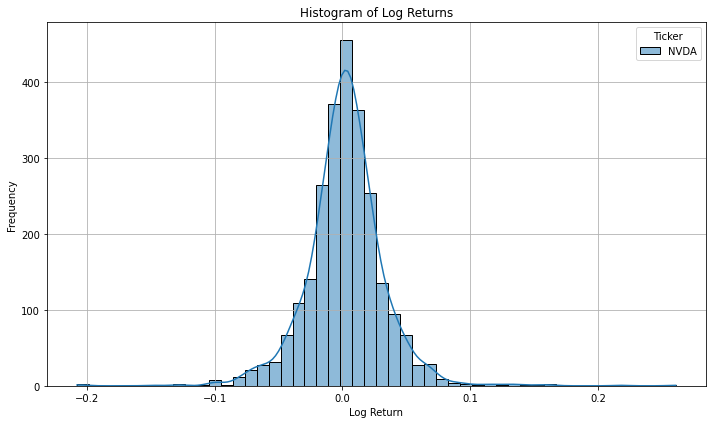

In [445]:
plt.figure(figsize=(10, 6))
sns.histplot(log_returns, bins=50, kde=True, color='steelblue')
plt.title('Histogram of Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

### Rolling Shapiro-Wilk test

This is a thresholding method for testing the CLT, or in our case, if the log-returns really follow a normal distribution

https://stats.stackexchange.com/questions/541379/testing-the-central-limit-theorem-with-the-shapiro-wilk-test-on-dice-rolling-sim

The _rolling_ Shapiro-Wilk test an extension/application of the Shapiro-Wilk test, where you apply the test repeatedly on moving windows (rolling windows) of a time series data. This is more appropriate in our case. Below, we consider a window of 1year (so 252 trading days).

In [446]:
window_length = 252
results = []

for i in range(len(log_returns) - window_length):
    segment = log_returns.iloc[i:i+window_length]
    stat, p_value = shapiro(segment)
    results.append({
        "start_date": log_returns.index[i],
        "end_date": log_returns.index[i+window_length-1],
        "p_value": p_value,
        "statistic": stat
    })

results_df = pd.DataFrame(results)
results_df['is_normal'] = results_df['p_value'] > 0.05

In [447]:
window_length = int(252/4)
results = []

for i in range(len(log_returns) - window_length):
    segment = log_returns.iloc[i:i+window_length]
    stat, p_value = shapiro(segment)
    results.append({
        "start_date": log_returns.index[i],
        "end_date": log_returns.index[i+window_length-1],
        "p_value": p_value,
        "statistic": stat
    })

results_df_quarter_year = pd.DataFrame(results)
results_df_quarter_year['is_normal'] = results_df_quarter_year['p_value'] > 0.05

In [448]:
results_df.head()

,start_date,end_date,p_value,statistic,is_normal
0,2015-01-05,2016-01-04,1.555021e-12,0.890493,False
1,2015-01-06,2016-01-05,1.553620e-12,0.890487,False
2,2015-01-07,2016-01-06,1.842651e-12,0.891612,False
3,2015-01-08,2016-01-07,3.016553e-12,0.894818,False
4,2015-01-09,2016-01-08,2.230186e-12,0.892861,False


In the plot below, we are carrying out the Hypothesis test:
- $H_0:$ The log returns are normally distributed
- $H_1:$ The log returns are _not_ normally distributed

We can then get the following conclusions:
- If the $p$-values $>0.05$, we conclude $H_0$, i.e. the log returns $\sim \mathcal{N}(\mu, \sigma^2)$
- If the $p$-values $<0.05$, we conclude $H_1$, i.e. the log returns $\not\sim \mathcal{N}(\mu, \sigma^2)$

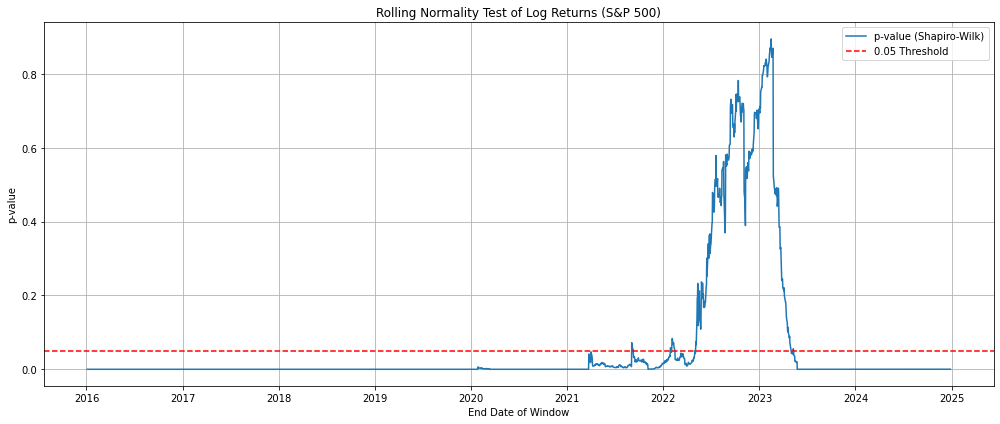

In [449]:
plt.figure(figsize=(14, 6))
plt.plot(results_df['end_date'], results_df['p_value'], label='p-value (Shapiro-Wilk)')
plt.axhline(0.05, color='red', linestyle='--', label='0.05 Threshold')
plt.title('Rolling Normality Test of Log Returns (S&P 500)')
plt.xlabel('End Date of Window')
plt.ylabel('p-value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Below, we shade the regions where we conclude $H_0$, i.e. where the log returns follow a normal distribution.

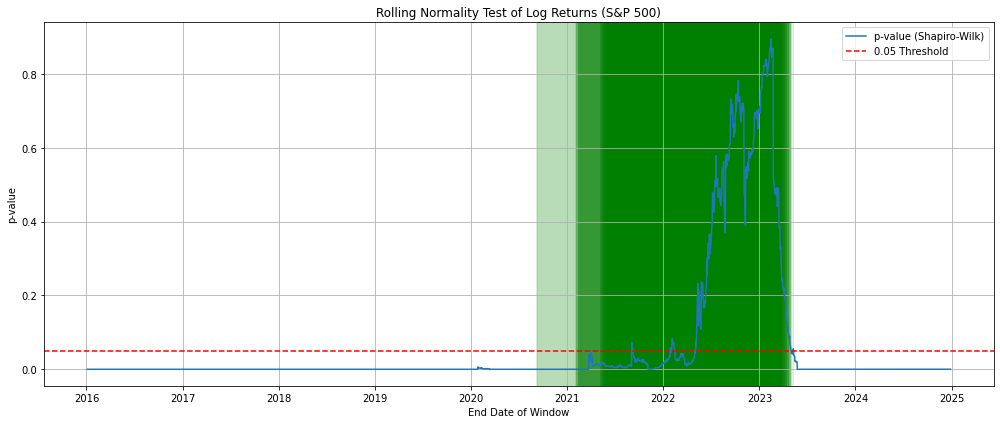

In [450]:
plt.figure(figsize=(14, 6))
plt.plot(results_df['end_date'], results_df['p_value'], label='p-value (Shapiro-Wilk)')
plt.axhline(0.05, color='red', linestyle='--', label='0.05 Threshold')

# shade normal-like regions
normal_periods = results_df[results_df['is_normal']]
for _, row in normal_periods.iterrows():
    plt.axvspan(row['start_date'], row['end_date'], color='green', alpha=0.1)

plt.title('Rolling Normality Test of Log Returns (S&P 500)')
plt.xlabel('End Date of Window')
plt.ylabel('p-value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Check other indices, side by side

In [451]:
tickers = ['^GSPC', 'TSLA', 'AAPL', 'G']
#results_dict = {t: rolling_normality_test(t) for t in tickers}
results_dict_annual = {t: rolling_normality_test(t, window=252) for t in tickers}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


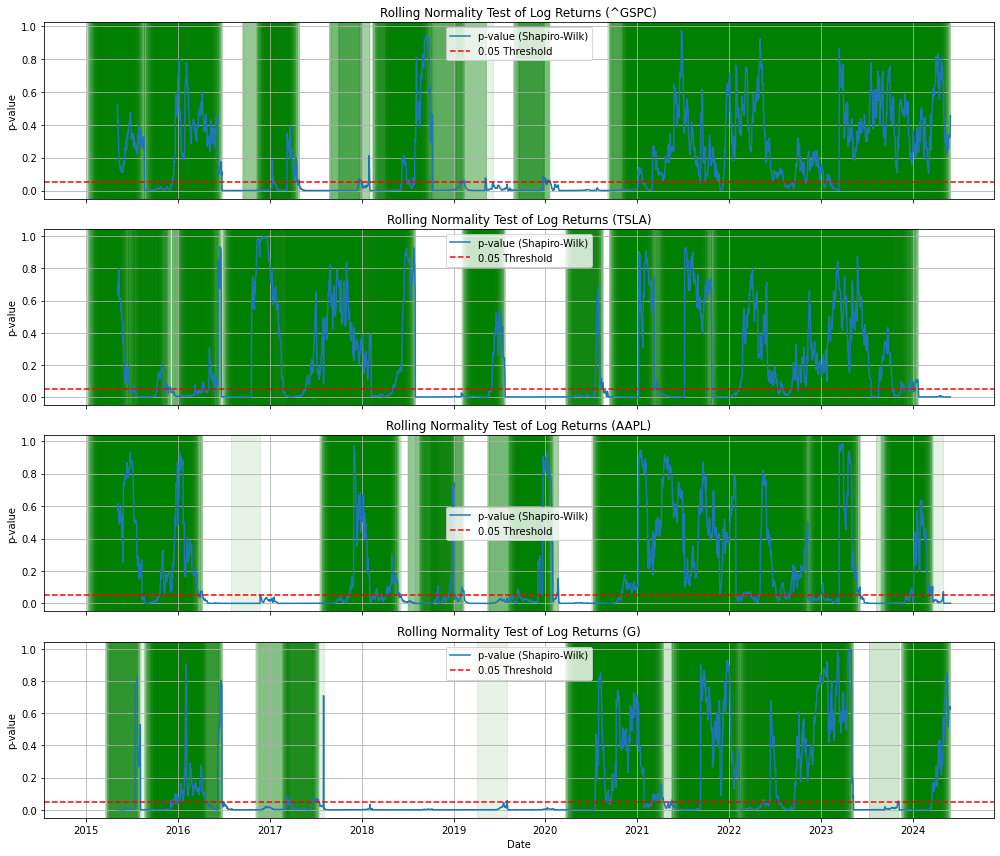

In [452]:
# Plot side-by-side
# This was only done for a one year window
fig, axes = plt.subplots(len(tickers), 1, figsize=(14, 12), sharex=True)

for ax, ticker in zip(axes, tickers):
    df = results_dict[ticker]
    ax.plot(df['end_date'], df['p_value'], label='p-value (Shapiro-Wilk)')
    ax.axhline(0.05, color='red', linestyle='--', label='0.05 Threshold')
    
    # Shade normal periods
    normal_periods = df[df['is_normal']]
    for _, row in normal_periods.iterrows():
        ax.axvspan(row['start_date'], row['end_date'], color='green', alpha=0.1)
    
    ax.set_title(f'Rolling Normality Test of Log Returns ({ticker})')
    ax.set_ylabel('p-value')
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

## Below we do the same for a quarterly window

Here we conclude that the (at least for these tickers), the smaller the rolling window in the Rolling Shapiro-Wilk test, there were more instances and in smaller lengths within which we concluded $H_0$, i.e. that the log-returns were normally distributed.

It is also worth noting that when we increased the period to two years, we would get longer instances (of the shaded green regions), which may be viewed as being consistent with the CLT and the "non-rolling" Shapiro-Wilk test, as more of the total log-returns were deduced to be normally distributed.

From these observations, it may good (for now) to stick with windows of length 1year.

In [453]:
window_length = int(252/3)

def rolling_normality_test(ticker, start='2015-01-01', end='2024-06-01', window=window_length):
    data = yf.download(ticker, start=start, end=end, auto_adjust=True)
    log_returns = np.log(data['Close'] / data['Close'].shift(1)).dropna()
    
    results = []
    for i in range(len(log_returns) - window):
        segment = log_returns.iloc[i:i+window]
        stat, p_value = shapiro(segment)
        results.append({
            "start_date": log_returns.index[i],
            "end_date": log_returns.index[i+window-1],
            "p_value": p_value,
            "statistic": stat
        })
    df = pd.DataFrame(results)
    df['is_normal'] = df['p_value'] > 0.05
    return df

tickers = ['^GSPC', 'TSLA', 'AAPL', 'G']
results_dict_quarter = {t: rolling_normality_test(t, window=window_length) for t in tickers}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


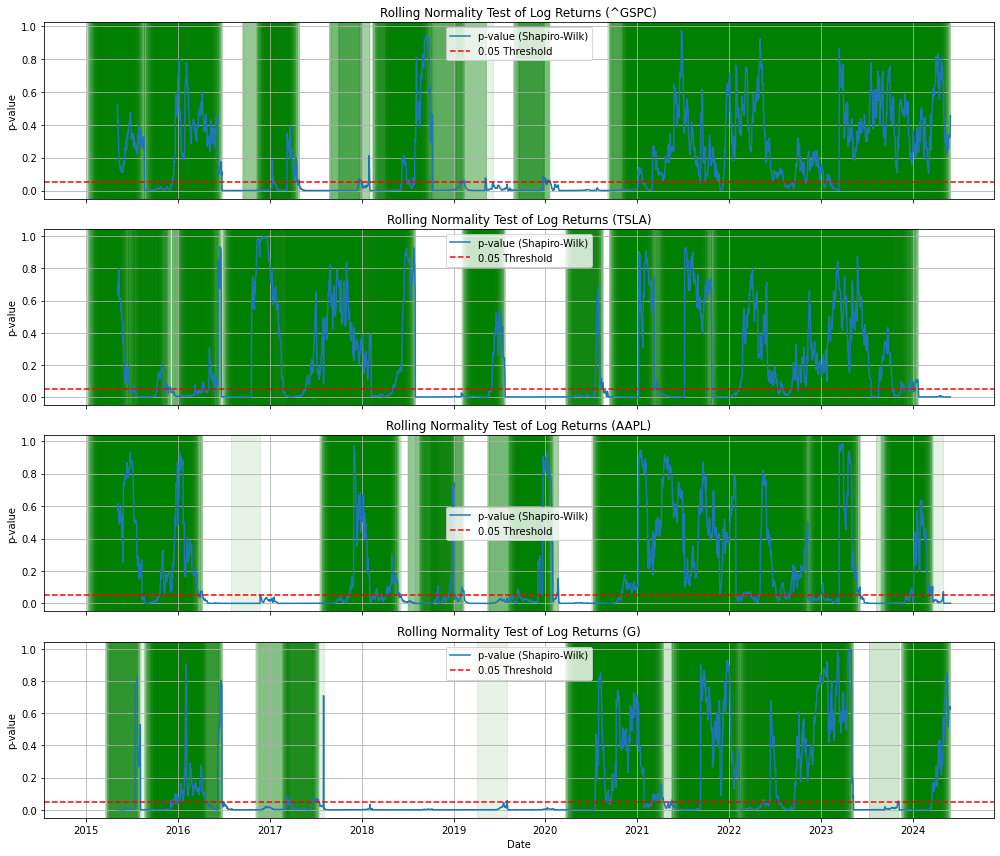

In [454]:
fig, axes = plt.subplots(len(tickers), 1, figsize=(14, 12), sharex=True)

for ax, ticker in zip(axes, tickers):
    df = results_dict_quarter[ticker]
    ax.plot(df['end_date'], df['p_value'], label='p-value (Shapiro-Wilk)')
    ax.axhline(0.05, color='red', linestyle='--', label='0.05 Threshold')
    
    # Shade normal periods
    normal_periods = df[df['is_normal']]
    for _, row in normal_periods.iterrows():
        ax.axvspan(row['start_date'], row['end_date'], color='green', alpha=0.1)
    
    ax.set_title(f'Rolling Normality Test of Log Returns ({ticker})')
    ax.set_ylabel('p-value')
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

### A lot of these seemed to not follow a normal distribution around 2020 (when I considered a window of 1year), which was the start of an unpleasant pandemic.

### Below we take a closer look into these, by comparing pre and post pandemic periods.

### I define **normality fraction** as the proportion of time periods in thr rolling windows during which the statistical test fails to reject the null hypothesis of normality (so we have normal distributions). In other words, it’s the fraction of windows where the data appears consistent with being normally distributed according to our selected threshold.

### **Interpretation**:
- If this fraction is to 1, then ost rolling periods show no strong evidence against normality — the log returns behave approximately like a normal distribution over time.
- If this fraction is close to 0, then log returns rarely look normal. The data likely has heavy tails, skewness, or jumps frequently, especially during turbulent market phases. Assuming normality would be misleading, and alternative models (e.g., heavy-tailed or non-Gaussian) asssumptions would be more appropriate.
- For ``moderate values'' (i.e. between 0.4 and 0.7), the log returns sometimes deviate from normality. Normality may hold in some periods (like stable markets) but fail in others (like during volatility spikes or crises), and modeling should be done with caution, considering possible fat tails or skewness.

In [455]:
results_df.head()

,start_date,end_date,p_value,statistic,is_normal
0,2015-01-05,2016-01-04,1.555021e-12,0.890493,False
1,2015-01-06,2016-01-05,1.553620e-12,0.890487,False
2,2015-01-07,2016-01-06,1.842651e-12,0.891612,False
3,2015-01-08,2016-01-07,3.016553e-12,0.894818,False
4,2015-01-09,2016-01-08,2.230186e-12,0.892861,False


In [456]:
pandemic_start = pd.Timestamp('2020-03-01')

def compare_periods(results_df):
    pre = results_df[results_df['end_date'] < pandemic_start]
    post = results_df[results_df['end_date'] >= pandemic_start]
    return {
        'pre_pandemic_normal_fraction': pre['is_normal'].mean(),
        'post_pandemic_normal_fraction': post['is_normal'].mean()
    }

In [457]:
print("=== Annual Window (252 trading days) ===")
for ticker, df in results_dict_annual.items():
    comp = compare_periods(df)
    print(f"{ticker}: Pre = {comp['pre_pandemic_normal_fraction']:.3f}, Post = {comp['post_pandemic_normal_fraction']:.3f}")

print("\n=== Quarterly Window (63 trading days) ===")
for ticker, df in results_dict_quarter.items():
    comp = compare_periods(df)
    print(f"{ticker}: Pre = {comp['pre_pandemic_normal_fraction']:.3f}, Post = {comp['post_pandemic_normal_fraction']:.3f}")


=== Annual Window (252 trading days) ===
^GSPC: Pre = 0.000, Post = 0.245
TSLA: Pre = 0.017, Post = 0.046
AAPL: Pre = 0.000, Post = 0.236
G: Pre = 0.000, Post = 0.021

=== Quarterly Window (63 trading days) ===
^GSPC: Pre = 0.291, Post = 0.707
TSLA: Pre = 0.392, Post = 0.507
AAPL: Pre = 0.297, Post = 0.534
G: Pre = 0.115, Post = 0.479


### **Conclusion**: We observe that with the quarterly rolling window, in general we had higher normality fractions. This means that in this case it is safer to assume normality in the data, compared to when we are assuming an annual window. This is an indication that various parameters could affect the underlying assumptions of the modeling techniques in place.

# 2) Test if removing extremal return data creates a distribution with evidence of being normal.

Through this method/approach, we want to see whether the non-normality in log returns is due to outliers (extreme returns), which may occur during crises or sudden spikes.

Above, we looked into something similar, where we tested the normality fraction pre and post pandemic; i.e. we took a certain global event into consideration and studied its affect/influence. The difference here is that we will remove such "outliers"/"unexpected events", to see whether or nor in the case where they were not present, if the log returns follow a normal distribution.

In [458]:
ticker = "^GSPC"
data = yf.download(ticker, start="2015-01-01", end="2024-06-01", auto_adjust=True)
log_returns = np.log(data['Close'] / data['Close'].shift(1)).dropna()

lower_quantile_perc = 1/100

low = log_returns.quantile(lower_quantile_perc)
high = log_returns.quantile(1-lower_quantile_perc)
filtered_returns = log_returns[(log_returns > low) & (log_returns < high)]

[*********************100%***********************]  1 of 1 completed


In [459]:
# The data for some reason had NaNs present, so I had to further clean this
print(f"Before cleaning:")
print(f"NaNs: {filtered_returns.isna().sum()}")
print(f"Infs: {np.isinf(filtered_returns).sum()}")
print(f"Length: {len(filtered_returns)}")

filtered_returns = filtered_returns[np.isfinite(filtered_returns)]
filtered_returns = filtered_returns.dropna()

print()
print('- - - - - - - - - - -')
print()

print(f"\nAfter cleaning:")
print(f"NaNs: {filtered_returns.isna().sum()}")
print(f"Infs: {np.isinf(filtered_returns).sum()}")
print(f"Variance: {filtered_returns.var()}")
print(f"Length: {len(filtered_returns)}")


Before cleaning:
NaNs: Ticker
^GSPC    48
dtype: int64
Infs: Ticker
^GSPC    0
dtype: int64
Length: 2368

- - - - - - - - - - -


After cleaning:
NaNs: Ticker
^GSPC    0
dtype: int64
Infs: Ticker
^GSPC    0
dtype: int64
Variance: Ticker
^GSPC    0.000081
dtype: float64
Length: 2320


In [460]:
# z-scores based filtering
z_scores = zscore(log_returns)
filtered_z_returns = log_returns[np.abs(z_scores) < 3]
#filtered_returns = log_returns[np.abs(z_scores) < 3]

In [461]:
stat_orig, p_orig = shapiro(log_returns)
stat_filt, p_filt = shapiro(filtered_returns)

# stat_orig, p_orig = normaltest(log_returns)  # Shapiro-Wilk
# stat_filt, p_filt = normaltest(filtered_returns)

if isinstance(p_orig, np.ndarray):
    p_orig = p_orig.item()
if isinstance(p_filt, np.ndarray):
    p_filt = p_filt.item()

print("Original log returns:")
print(f"Shapiro-Wilk p-value: {p_orig:.4f} -> {'Normal' if p_orig > 0.05 else 'Not normal'}")

print("\nFiltered log returns (outliers removed):")
print(f"Shapiro-Wilk p-value: {p_filt:.4f} -> {'Normal' if p_filt > 0.05 else 'Not normal'}")

Original log returns:
Shapiro-Wilk p-value: 0.0000 -> Not normal

Filtered log returns (outliers removed):
Shapiro-Wilk p-value: 0.0000 -> Not normal


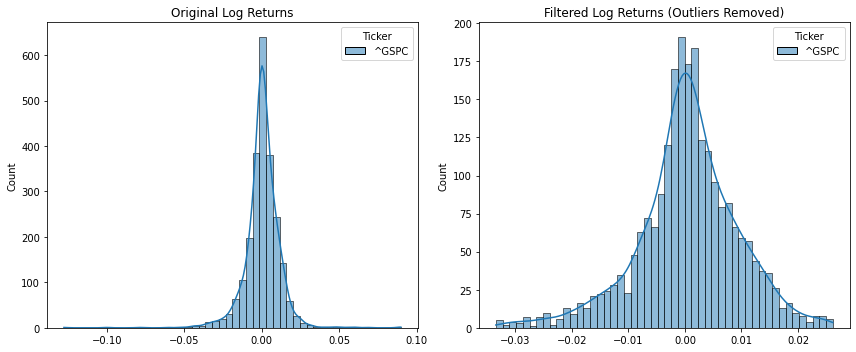

In [462]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(log_returns, bins=50, kde=True, color='red')
plt.title('Original Log Returns')

plt.subplot(1, 2, 2)
sns.histplot(filtered_returns, bins=50, kde=True, color='green')
plt.title('Filtered Log Returns (Outliers Removed)')

plt.tight_layout()
plt.show()

By observation, it seems that the data actual fits a Laplace distribution, which is what I am testing below

Below, **D-statistic** is the maximum absolute difference between the empirical cumulative distribution function (ECDF) of your sample data and the cumulative distribution function (CDF) of the reference distribution.

In [463]:
# Fit Laplace distribution and carry out a Kolmogorov-Smirnov test
loc, scale = laplace.fit(log_returns)
loc = float(loc)       # estimated location parameter (the center/mean of the distribution)
scale = float(scale)   # estimated scale parameter (controls the spread/width of the distribution)

D, p_value_laplace = kstest(log_returns, 'laplace', args=(loc, scale))
D_filt, p_value_filt_laplace = kstest(filtered_returns, 'laplace', args=(loc, scale))

print(f"Laplace fit parameters: loc = {loc:.5f}, scale = {scale:.5f}")
print(f"Kolmogorov-Smirnov test for Laplace:")
print(f"D-statistic = {D.item():.4f}, p-value = {p_value_laplace.item():.4f}")
print("  => The log returns", "fit a Laplace distribution" if p_value_laplace > 0.05 else "do NOT fit a Laplace distribution")

print()
print('- - - - - - - - - - -')
print()

print(f"Laplace fit parameters: loc = {loc:.5f}, scale = {scale:.5f}")
print(f"Kolmogorov-Smirnov test for Laplace:")
print(f"D-statistic = {D_filt.item():.4f}, p-value = {p_value_filt_laplace.item():.4f}")
print("  => The FILTERED log returns", "fit a Laplace distribution" if p_value_filt_laplace > 0.05 else "do NOT fit a Laplace distribution")

Laplace fit parameters: loc = 0.00060, scale = 0.00739
Kolmogorov-Smirnov test for Laplace:
D-statistic = 0.0257, p-value = 0.0855
  => The log returns fit a Laplace distribution

- - - - - - - - - - -

Laplace fit parameters: loc = 0.00060, scale = 0.00739
Kolmogorov-Smirnov test for Laplace:
D-statistic = 0.0303, p-value = 0.0277
  => The FILTERED log returns do NOT fit a Laplace distribution


By a simple test, similar to the normality tests from the notebooks, we deduce that the log returns do fit a Laplace distribution, though the log returns do not, for the given index. This makes sense, as the the Laplace distribution has more probability in the tails (heavier tails), which means it is better at modeling extreme values or outliers; which was the task of this portion in the mini project (to see the effect of the outliers).

This was also the case when I filtered the log returns according to the z-scores. Furthermore, the more I filtered (i.e. had higher values for the variable `lower_quantile_perc`), the father away (visually) from a symmetric or Gaussian distribution, the filtered data would be.

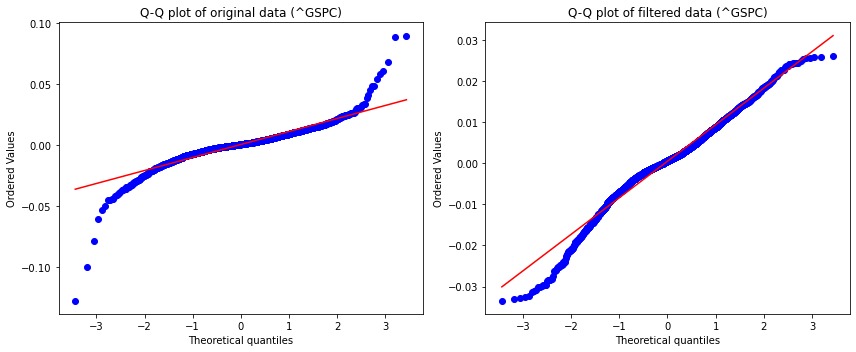

In [464]:
## Do the same test that was done in the provided notebook
log_returns_1d = log_returns.values.ravel()  # flattens the array into a 1D array
filtered_returns_1d = filtered_returns.values.ravel()  # flattens the array into a 1D array

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

stats.probplot(log_returns_1d, dist="norm", plot=ax1)
ax1.set_title(f'Q-Q plot of original data ({ticker})', fontsize=12)

stats.probplot(filtered_returns_1d, dist="norm", plot=ax2)
ax2.set_title(f'Q-Q plot of filtered data ({ticker})', fontsize=12)

plt.tight_layout()
plt.show()

In [473]:
# D’Agostino and Pearson’s test
p_log_returns = stats.normaltest(log_returns_1d)[1]
p_filtered_returns = stats.normaltest(filtered_returns_1d)[1]

# Store in dictionary
p_value_dict = {
    'Original Log Returns': p_log_returns,
    'Filtered Log Returns': p_filtered_returns
}

print("Normality Test Results (D'Agostino and Pearson's Test):")
print("=" * 60)
for name, p in p_value_dict.items():
    print(f"{name}: p-value = {p:.4f}")
    if p < 0.05:
        print("Statistically significant evidence that the data is NOT normally distributed.")
    else:
        print("No statistically significant evidence against normality.")
    print("-" * 60)

Normality Test Results (D'Agostino and Pearson's Test):
Original Log Returns: p-value = 0.0000
Statistically significant evidence that the data is NOT normally distributed.
------------------------------------------------------------
Filtered Log Returns: p-value = 0.0000
Statistically significant evidence that the data is NOT normally distributed.
------------------------------------------------------------


##  3) Create a personalized portfolio of stocks with historical log return data that is normally distributed

Here, it may also be beneficial to consider tickers from different sectors. Maybe one sector inherently has a different distribution in its data, compared to another sector.

In [466]:
#tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'JPM', 'V', 'PG', 'TSLA']
tickers = [
    # Tech
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'ORCL', 'ADBE', 'INTC', 'PLTR',
    # Financials
    'JPM', 'V', 'MA', 'BAC', 'GS', 'AXP', 'C', 'MS', 'BLK', 'SCHW',
    # Healthcare
    'PFE', 'JNJ', 'MRK', 'LLY', 'BMY', 'UNH', 'CVS', 'ABT', 'TMO', 'MDT',
    # Consumer
    'PG', 'KO', 'PEP', 'COST', 'WMT', 'MCD', 'NKE', 'SBUX', 'HD', 'TGT'
]

# Download adjusted close prices (auto_adjust=True)
data = yf.download(tickers, start="2015-01-01", end="2024-12-31", auto_adjust=True)['Close']

log_returns = np.log(data / data.shift(1)).dropna()

[*********************100%***********************]  41 of 41 completed


In [467]:
print()
print(f'We have a total of {len(tickers)} tickers')


We have a total of 41 tickers


In [468]:
# Normality test per stock
normality_results = {}
for ticker in log_returns.columns:
    stat, p_value = normaltest(log_returns[ticker].dropna())
    normality_results[ticker] = p_value

# Stocks passing normality test at a given significance level% significance
sign_level = 0.4
sign_level = 0.05
normally_distributed_stocks = [t for t, p in normality_results.items() if p > sign_level]

print(f"Stocks with normally distributed log returns (p > {sign_level}):")
print(normally_distributed_stocks)

if len(normally_distributed_stocks) == 0:
    print(f"No stocks passed the normality test at p > {sign_level}.")
    portfolio_returns = log_returns.mean(axis=1)
else:
    portfolio_returns = log_returns[normally_distributed_stocks].mean(axis=1).dropna()

#print(f"Number of portfolio return data points: {len(portfolio_returns)}")


Stocks with normally distributed log returns (p > 0.05):
[]
No stocks passed the normality test at p > 0.05.


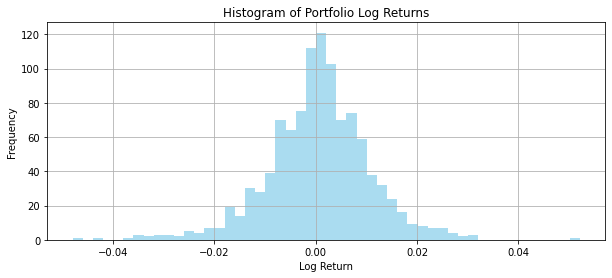

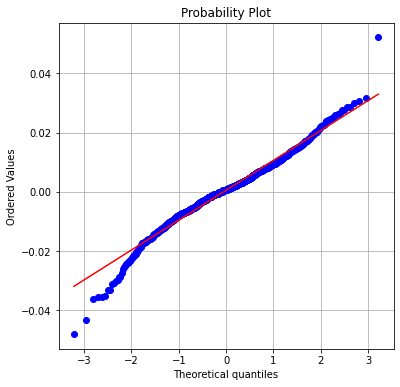

In [469]:
# Histogram
plt.figure(figsize=(10,4))
plt.hist(portfolio_returns, bins=50, alpha=0.7, color='skyblue')
plt.title('Histogram of Portfolio Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Q-Q plot
plt.figure(figsize=(6,6))
plt.title("Q-Q Plot: Portfolio Log Returns vs Normal Distribution")
probplot(portfolio_returns, dist="norm", plot=plt)
plt.grid(True)
plt.show()

### The above was unsuccessful -- I did not get any normally distributed data. I tried the same thing with Laplace data which was more successful

In [470]:
# Laplace goodness-of-fit test per stock (using KS test)
laplace_fit_results = {}
for ticker in log_returns.columns:
    sample = log_returns[ticker].dropna()
    loc, scale = laplace.fit(sample)
    stat, p_value = kstest(sample, 'laplace', args=(loc, scale))
    laplace_fit_results[ticker] = p_value

sign_level_laplace = 0.05
laplace_stocks = [t for t, p in laplace_fit_results.items() if p > sign_level_laplace]

print(f"Stocks with log returns fitting Laplace distribution (p > {sign_level_laplace}):")
print(laplace_stocks)

if len(laplace_stocks) == 0:
    print(f"No stocks passed the Laplace goodness-of-fit test at p > {sign_level_laplace}")
    portfolio_returns = log_returns.mean(axis=1)
else:
    portfolio_returns = log_returns[laplace_stocks].mean(axis=1).dropna()

#print(f"Number of portfolio return data points: {len(portfolio_returns)}")
print()
print(f'A total of {len(laplace_stocks)} tickers follow a Laplace distribution')


Stocks with log returns fitting Laplace distribution (p > 0.05):
['AAPL', 'ABT', 'ADBE', 'AMZN', 'AXP', 'BAC', 'BMY', 'C', 'COST', 'CVS', 'GOOGL', 'GS', 'HD', 'INTC', 'JNJ', 'JPM', 'KO', 'LLY', 'MA', 'MCD', 'MDT', 'META', 'MRK', 'MS', 'MSFT', 'NKE', 'ORCL', 'PEP', 'PFE', 'PG', 'PLTR', 'SBUX', 'SCHW', 'TGT', 'TSLA', 'UNH', 'V', 'WMT']

A total of 38 tickers follow a Laplace distribution


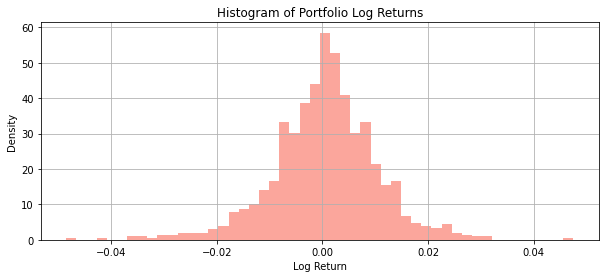

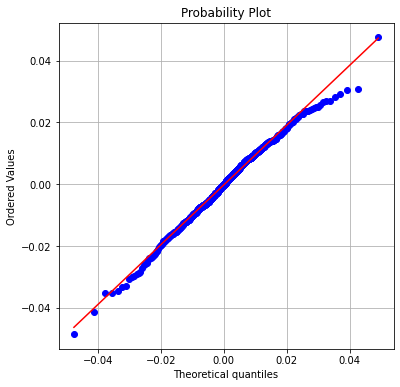

In [ ]:
plt.figure(figsize=(10,4))
plt.hist(portfolio_returns, bins=50, alpha=0.7, color='salmon', density=True)
plt.title('Histogram of Portfolio Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.grid(True)
plt.show()

plt.figure(figsize=(6,6))
plt.title("Q-Q Plot: Portfolio Log Returns vs Laplace Distribution")

# Fit Laplace params on portfolio returns
loc_port, scale_port = laplace.fit(portfolio_returns)

# Generate theoretical quantiles and ordered values
probplot(portfolio_returns, dist=laplace, sparams=(loc_port, scale_port), plot=plt)

plt.grid(True)
plt.show()